# Implementing an Physics-informed neural network for the 1D Heat equation using the PINN framework.

In [3]:
import sys
import numpy as np
import scipy.io
import torch
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from torch.nn import Module

sys.path.append('/content/drive/MyDrive/NeuralSolvers-master')  # PINNFramework etc.
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


### Underlying PDE

**PDE:** $ u_{t}=k u_{x x} $ &emsp; $ 0 < x < 1 $




In [4]:
class InitialConditionDataset(Dataset):

    def __init__(self, n0):

        super(type(self)).__init__()
        data=pd.read_csv('2021-02-20_battHeater_outside_temp9.0C_IC4.66.csv')
        u = pd.DataFrame(data, columns= ['Temperature(℃)']).to_numpy()
        t = np.arange(0,u.size*60,60).reshape((u.size, 1))
        x= np.linspace(0, 1, num=200)
        x=x.reshape((x.size,1))

        idx_x = np.random.choice(x.shape[0], n0, replace=False)
        self.x = x[idx_x,:]
        self.u = u[idx_x,:]
        self.t = np.zeros(self.x.shape)

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

    def __getitem__(self, idx):
        x = np.concatenate([self.x, self.t], axis=1)
        y = np.concatenate([self.u], axis=1)

        return Tensor(x).float(), Tensor(y).float()

In [5]:
class PDEDataset(Dataset):
    def __init__(self, nf, lb, ub):
        self.xf = lb + (ub - lb) * lhs(2, nf)

    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.xf).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

In [6]:
    def derivatives(x, u):
        u = u[:, 0]
        print("x:", x.shape)
        grads = ones(u.shape, device=u.device) # move to the same device as prediction
        grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]

        # calculate first order derivatives
        u_x = grad_u[:, 0]
        print("u_x", u_x.shape)
        u_t = grad_u[:, 1]

        # calculate second order derivatives
        grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]

        u_xx = grad_u_x[:, 0]
        print("u_xx", u_xx.shape)

        x, t = x.T
        x = x.reshape(u.shape)
        t = t.reshape(u.shape)

        return torch.stack([x, t, u,
                        u_xx, u_t], 1).squeeze()

In [7]:
class HPM(Module):

    def __init__(self, kappa_net: Module):
        """
        Constructor of the HPM Model 
        """
        super(HPM, self).__init__()
        self.kappa_net = kappa_net
  
    def forward(self, derivatives):

        kappa_net_input = derivatives[:, :2]
        kappa_output = self.kappa_net(kappa_net_input)
        kappa_output = kappa_output.view(-1)

        u_xx = derivatives[:, 3].view(-1)

        predicted_u_t = kappa_output * (u_xx)

        return predicted_u_t


In [8]:
if __name__ == "__main__":
    # Domain bounds
    lb = np.array([0.0, 0.0])
    ub = np.array([1, 12600])

    # initial condition
    ic_dataset = InitialConditionDataset(n0=20)
    initial_condition = pf.InitialCondition(ic_dataset)

    pde_dataset = PDEDataset(20000, lb, ub)

    # Diffusivity model
    # Input: x,t
    # Output: diffusivity k
    kappa_net = pf.models.MLP(input_size=2,
                              output_size=1,
                              hidden_size=100,
                              num_hidden=4,
                              lb = lb ,
                              ub = ub)
    
    # PINN model
    # Input: x,t
    # Output: temperature u at the point
    model = pf.models.MLP(input_size=2,
                          output_size=1, 
                          hidden_size=100, 
                          num_hidden=4, 
                          lb=lb, 
                          ub=ub)
    kappa_net.cuda()
    hpm_model = HPM(kappa_net)

    hpm_loss = pf.HPMLoss.HPMLoss(pde_dataset, derivatives, hpm_model)
    pinn = pf.PINN(model, 2, 1, hpm_loss, initial_condition, boundary_condition=None, use_gpu=True)
    pinn.fit(40000, 'Adam', 1e-4)



Streaming output truncated to the last 5000 lines.
u_x torch.Size([20000])
u_xx torch.Size([20000])
PINN Loss 5.4917858506087214e-05 Epoch 38765 from 40000
x: torch.Size([20000, 2])
u_x torch.Size([20000])
u_xx torch.Size([20000])
PINN Loss 5.5060598242562264e-05 Epoch 38766 from 40000
x: torch.Size([20000, 2])
u_x torch.Size([20000])
u_xx torch.Size([20000])
PINN Loss 5.5282118410104886e-05 Epoch 38767 from 40000
x: torch.Size([20000, 2])
u_x torch.Size([20000])
u_xx torch.Size([20000])
PINN Loss 5.562831574934535e-05 Epoch 38768 from 40000
x: torch.Size([20000, 2])
u_x torch.Size([20000])
u_xx torch.Size([20000])
PINN Loss 5.615715417661704e-05 Epoch 38769 from 40000
x: torch.Size([20000, 2])
u_x torch.Size([20000])
u_xx torch.Size([20000])
PINN Loss 5.6976878113346174e-05 Epoch 38770 from 40000
x: torch.Size([20000, 2])
u_x torch.Size([20000])
u_xx torch.Size([20000])
PINN Loss 5.824465915793553e-05 Epoch 38771 from 40000
x: torch.Size([20000, 2])
u_x torch.Size([20000])
u_xx torch.

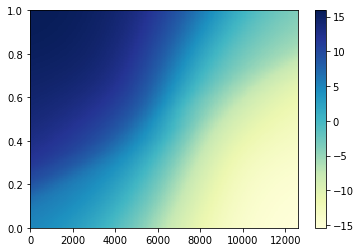

Pred u value at x=1: [[  4.9219317 ]
 [  4.8848352 ]
 [  4.846502  ]
 [  4.8069267 ]
 [  4.7661133 ]
 [  4.7240634 ]
 [  4.680779  ]
 [  4.636265  ]
 [  4.590521  ]
 [  4.543548  ]
 [  4.495344  ]
 [  4.4459043 ]
 [  4.395222  ]
 [  4.343289  ]
 [  4.2900934 ]
 [  4.235621  ]
 [  4.179859  ]
 [  4.1227894 ]
 [  4.064393  ]
 [  4.0046496 ]
 [  3.9435387 ]
 [  3.8810382 ]
 [  3.8171268 ]
 [  3.7517776 ]
 [  3.6849687 ]
 [  3.6166782 ]
 [  3.5468771 ]
 [  3.475547  ]
 [  3.40266   ]
 [  3.3281944 ]
 [  3.2521284 ]
 [  3.1744375 ]
 [  3.0951028 ]
 [  3.014103  ]
 [  2.9314172 ]
 [  2.8470278 ]
 [  2.7609184 ]
 [  2.6730685 ]
 [  2.5834672 ]
 [  2.492096  ]
 [  2.3989453 ]
 [  2.3040013 ]
 [  2.2072544 ]
 [  2.108694  ]
 [  2.0083134 ]
 [  1.9061038 ]
 [  1.8020617 ]
 [  1.6961803 ]
 [  1.5884593 ]
 [  1.4788954 ]
 [  1.3674887 ]
 [  1.2542378 ]
 [  1.1391493 ]
 [  1.0222214 ]
 [  0.9034634 ]
 [  0.78287745]
 [  0.6604746 ]
 [  0.53626204]
 [  0.4102485 ]
 [  0.28244916]
 [  0.15287405]
 [ 

In [9]:
    # Plotting
    data=pd.read_csv('2021-02-20_battHeater_outside_temp9.0C_IC4.66.csv')
    u = pd.DataFrame(data, columns= ['Temperature(℃)']).to_numpy()
    t = np.arange(0,u.size*60,60).reshape((u.size, 1))
    x= np.linspace(0, 1, num=200)
    x=x.reshape((x.size,1))

    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = u.T.flatten()[:, None]

    pred = model(Tensor(X_star).cuda())
    pred = pred.detach().cpu().numpy()
    H_pred = pred.reshape(X.shape)
    plt.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu',
                  extent= [lb[1], ub[1], lb[0], ub[0]],
                  origin='lower', aspect='auto')
    plt.colorbar()
    plt.show()

    print('Pred u value at x=1:', (H_pred.T[0,:].flatten()[:, None]))
    print('Exact u value at x=1',u.flatten()[:, None])
